In [46]:
%reload_ext autoreload
%autoreload 2

from scara.ptservo import PTServoArduino
from scara.kinematics import mk_kine_pair
from time import sleep
import pandas as pd

serial_port = '/dev/tty.usbmodem22121401'  # Replace with your serial port
baud_rate = 115200  # Replace with your baud rate

pt_servo = PTServoArduino(serial_port, baud_rate)

pt_servo.move_a(90, 90)
sleep(1)
print(pt_servo.check_status())
pt_servo.move_a(45, 45)
sleep(1)
print(pt_servo.check_status())
pt_servo.move_a(45, 90)
sleep(1)
print(pt_servo.check_status())

pt_servo.ser.close()


Opened serial port /dev/tty.usbmodem22121401


Sending angles: 27000, 27000 with code a
27000
18000
9000
27000
18000
9000
recv: a 9000.00 9000.00
pos: 90.00 0.00
pos: 90.00 90.00
ready.

Sending angles: 22500, 22500 with code a
22500
18000
4500
22500
18000
4500
recv: a 4500.00 4500.00
pos: 45.00 90.00
pos: 45.00 45.00
ready.

Sending angles: 22500, 27000 with code a
22500
18000
4500
27000
18000
9000
recv: a 4500.00 9000.00
pos: 45.00 45.00
pos: 45.00 90.00
ready.



In [112]:
from math import cos, sin, pi

l1 = 103
l2 = 110
forward, inverse = mk_kine_pair(l1, l2)


def move(servo, x, y):
    # Calculate the angles using the inverse kinematics
    
    angles = inverse(x, y, True)
   
    # Move the servo motors to the calculated angles
    servo.move_a(*angles)
    print(servo.check_status())
    return angles
   
def interpolate_points(x1, y1, x2, y2, n):
    return [(x1 + i * (x2 - x1) / (n - 1), y1 + i * (y2 - y1) / (n - 1)) for i in range(n)]

def draw_points(servo, positions):
    d = []
    for  p1, p2 in zip(positions, positions[1:] + [positions[0]]):


        points = interpolate_points(*p1, *p2, 50)
        
        for x, y in points:
            r = [x,y]
            r += list(move(servo, x, y))
            #sleep(0.05)  # Adjust the sleep time as needed
            r += [servo.x, servo.y, servo.px, servo.py]
            d.append(r)
            
    df = pd.DataFrame(d, columns=['cx', 'cy', 'a1', 'a2', 'ax','ay', 'px', 'py'])
    
    return df

x_min, x_max = -100, 0
y_min, y_max = 50, 125

positions = [(x_min, y_min), 
             (x_min, y_max), 
             (x_max, y_max), 
             (x_max, y_min)]

def generate_circle_points(x, y, r, n):
    return [(x + r * cos(2 * pi * i / n), y + r * sin(2 * pi * i / n)) for i in range(n)]


servo = PTServoArduino(serial_port, baud_rate)
print(servo.check_status())

df = draw_points(servo, positions)
df['px'] = df['px'].astype(float)
df['py'] = df['py'].astype(float)

servo.ser.close()
df

Opened serial port /dev/tty.usbmodem22121401














































































































































































































,cx,cy,a1,a2,ax,ay,px,py
0,-100.000000,50.000000,91.989647,63.222334,92.0,63.2,380.0,300.0
1,-100.000000,51.530612,91.538055,63.661628,91.5,63.7,379.0,301.0
2,-100.000000,53.061224,91.101204,64.112429,91.1,64.1,378.0,303.0
3,-100.000000,54.591837,90.679055,64.574634,90.7,64.6,376.0,304.0
4,-100.000000,56.122449,90.271557,65.048142,90.3,65.0,375.0,305.0
...,...,...,...,...,...,...,...,...
195,-91.836735,50.000000,87.434865,58.691977,87.4,58.7,367.0,288.0
196,-93.877551,50.000000,88.592855,59.807099,88.6,59.8,371.0,291.0
197,-95.918367,50.000000,89.737406,60.933831,89.7,60.9,374.0,294.0
198,-97.959184,50.000000,90.869389,62.072219,90.9,62.1,377.0,297.0


In [103]:
df.dtypes

cx    float64
cy    float64
a1    float64
a2    float64
ax    float64
ay    float64
px    float64
py    float64
dtype: object

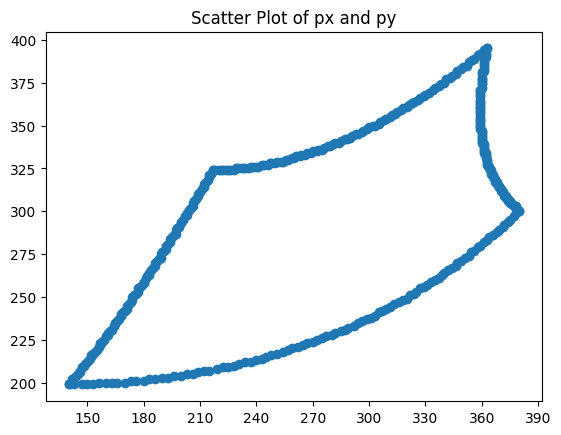

In [109]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

SERVOMIN = 125  # minimum pulse length count (out of 4096)
SERVOMAX = 625  # maximum pulse length count (out of 4096)
ANGLE_SCALE = 100

def angle_to_pulse(ang):
    pulse = int((ang - 0 * ANGLE_SCALE) * (SERVOMAX - SERVOMIN) / (180 * ANGLE_SCALE - 0 * ANGLE_SCALE) + SERVOMIN)
    print(f"{ang} {pulse}")
    return pulse

plt.scatter(df['px'], df['py'])

#plt.scatter(df['ay'], df['py'].apply(angle_to_pulse), color='red')

plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=10))
plt.title('Scatter Plot of px and py')

plt.show()

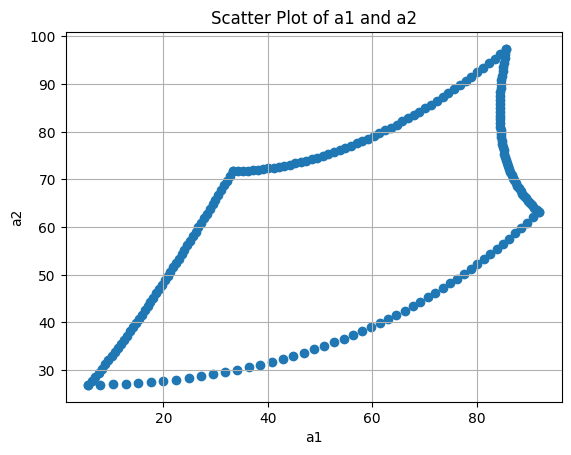

In [81]:
plt.scatter(df['a1'], df['a2'])
plt.xlabel('a1')
plt.ylabel('a2')
plt.title('Scatter Plot of a1 and a2')
plt.grid(True)
plt.show()